# Exercise 1: The Brownian Bridge

*This notebook was created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.*

**Using a Jupyter Notebook**. After opening a Jupyper notebook in an editing environment (local or a cloud-hosted environment), no variables or functions are present in the namespace. As cells in the notebook are run, variables and functions become part of the namespace and are now usable in later cells. If you restart the notebook, the namespace is cleared and you will need to re-run cells to reinitialize any functions or variables needed for later cells

Running the cells below will run a "preamble," which imports external packages and code into the Jupyter Notebook environment. This includes external Python libraries, as well as internal code on which

Requirements for this lesson:
+ matplotlib
+ numpy
+ scipy


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Autoreload
# %load_ext autoreload
# %autoreload 2

**A note on cloud-hosted notebooks.** If you are running a notebook on a cloud provider, such as Google Colab or CodeOcean, remember to save your work frequently. Cloud notebooks will occasionally restart after a fixed duration, crash, or prolonged inactivity, requiring you to re-run code.

In [2]:
import os
## print current working directory
print(os.getcwd())

/Users/william/program_repos/cphy/hw


In [3]:
cwd = os.getcwd()
user = os.environ.get("USER")  # often 'root' in Colab
print(f"User: {user}, CWD: {cwd}")

User: william, CWD: /Users/william/program_repos/cphy/hw


In [ ]:
def simulate_bridge(x0, xf, proc = lambda x: x):
    

## The Brownian Bridge

A **Brownian bridge** is a stochastic process that can be thought of as a Brownian motion that is "pinned" to start and end at fixed values over a fixed interval. The Brownian bridge thus describes the distribution of random walks that start and end at the same point.
An example of a Brownian bridge is the random motion of biological polymers, like DNA, which are confined to a fixed length. In such systems, the polymer’s configuration fluctuates randomly in the interior, but the two ends are constrained---either by being chemically bound, as in circular DNA, or by attachment to fixed sites within a cell.

If we denote $\{W(t): 0 \leq t \leq 1\}$ to describe standard Brownian motion on an interval of length 1, the Brownian bridge $\\{B(t): 0 \leq t \leq 1\\}$ is defined as

$$
    B(t) = W(t) - t W(1).
$$

Physically, this means that the particle is pinned to the origin at $t=0$ and $t=1$, and is free to move in between. The Brownian bridge is a Gaussian process, meaning that any finite collection of values of the process is jointly Gaussian distributed.

A critical property of the Brownian bridge is that it is a martingale. This means that the expected value of the process at any future time is equal to the current value. We can write this as

$$
    \mathbb{E}[B(t)] = B(t).
$$

As a result, we can write the Brownian bridge as a transformation of Brownian motion:

$$
    B(t) = t\, W(1) + (1-t)\, W(0).
$$

where $T$ is the total length of the interval and $t$ is the current time between 0 and $1$.





The key properties of the Brownian bridge are:

1. **Gaussian process:**  
   $B(t)$ is jointly Gaussian for any finite collection of times because it is a linear transformation of Brownian motion.

2. **Mean:**  
   $$
   \mathbb{E}[B(t)] = 0.
   $$

3. **Covariance function:**  
   For \(0 \leq s, t \leq 1\),
   $$
   \mathrm{Cov}(B(s), B(t)) = \min(s,t) - st.
   $$

   - Notice that \(\mathrm{Var}(B(t)) = t(1-t)\), which vanishes at \(t=0\) and \(t=1\).  
   - This reflects the fact that the process is "pinned" at both ends.

4. **Continuity:**  
   Since \(B(t)\) is obtained from continuous Brownian motion, it has continuous sample paths.

5. **Distribution at fixed \(t\):**  
   $$
   B(t) \sim \mathcal{N}\big(0, \, t(1-t)\big).
   $$

---

## Intuition

- Think of Brownian motion \(W(t)\) as a random walk with continuous time and space.  
- The Brownian bridge is what you get if you *force* that random walk to end at zero at \(t=1\).  
- In other words, \(B(t)\) models a Brownian particle that starts at 0, wanders randomly, but is constrained to return to 0 at a fixed future time.

---





In [ ]:
# Brownian bridge simulation and comparison to analytic results
import numpy as np
import matplotlib.pyplot as plt
from math import pi, sqrt, exp

# --- parameters ---
T = 1.0
a, b = 0.0, 0.0                   # standard bridge
n_paths = 10000                   # number of sample paths
n_steps = 1000                    # time grid resolution
rng = np.random.default_rng(1234) # reproducible

t = np.linspace(0.0, T, n_steps + 1)             # grid: 0,...,T
dt = T / n_steps
t_over_T = t / T

# --- simulate Brownian motion W ---
dW = rng.normal(0.0, sqrt(dt), size=(n_paths, n_steps))  # increments
W = np.empty((n_paths, n_steps + 1))
W[:, 0] = 0.0
np.cumsum(dW, axis=1, out=W[:, 1:])                      # cumulative sum into W[:,1:]

# --- make it a Brownian bridge X ---
# X_t = a + (t/T)(b-a) + W_t - (t/T) W_T
WT = W[:, -1][:, None]
X = a + (t_over_T * (b - a))[None, :] + W - t_over_T[None, :] * WT

# --- analytic mean, variance, covariance ---
mean_analytic = a + t * (b - a) / T
var_analytic = t * (1.0 - t / T)

def cov_analytic(s, u, T=1.0):
    s, u = float(s), float(u)
    return min(s, u) - (s * u) / T

# --- empirical moments ---
emp_mean = X.mean(axis=0)
emp_var = X.var(axis=0, ddof=0)

# pick one time s to examine covariance vs t
s_idx = int(0.35 * n_steps)        # s ≈ 0.35
s = t[s_idx]
emp_cov_vs_t = (X * X[:, s_idx][:, None]).mean(axis=0) - emp_mean * emp_mean[s_idx]
cov_vs_t_analytic = np.minimum(t, s) - (t * s) / T

# --- basic error metrics ---
mean_rmse = np.sqrt(np.mean((emp_mean - mean_analytic)**2))
var_rmse  = np.sqrt(np.mean((emp_var  - var_analytic )**2))
cov_rmse  = np.sqrt(np.mean((emp_cov_vs_t - cov_vs_t_analytic)**2))

print(f"RMSE(mean) = {mean_rmse:.3e}")
print(f"RMSE(var)  = {var_rmse:.3e}")
print(f"RMSE(cov at s={s:.3f}) = {cov_rmse:.3e}")

# --- distribution check at a fixed time t* ---
tstar_idx = int(0.6 * n_steps)     # t* ≈ 0.6
tstar = t[tstar_idx]
samples_tstar = X[:, tstar_idx]
mu_t = mean_analytic[tstar_idx]
sigma_t = sqrt(var_analytic[tstar_idx])

# z-scores to check standard normality
z = (samples_tstar - mu_t) / sigma_t
print(f"z-mean ≈ {z.mean():.3e}, z-std ≈ {z.std(ddof=0):.3f} (should be ~0,~1)")

# --- Kolmogorov distribution for sup |bridge| ---
sup_abs = np.max(np.abs(X), axis=1)

def kolmogorov_cdf(x, K=200):
    # 1 - 2 * sum_{k=1}^\infty (-1)^{k-1} e^{-2 k^2 x^2}
    # truncate at K terms (K large enough for plotted range)
    k = np.arange(1, K+1)[:, None]
    terms = (-1.0)**(k-1) * np.exp(-2.0 * (k**2) * (x[None, :]**2))
    return 1.0 - 2.0 * np.sum(terms, axis=0)

# prepare ECDF for sup|X| and compare to analytic
x_grid = np.linspace(0.05, np.quantile(sup_abs, 0.999), 300)
ecdf = np.searchsorted(np.sort(sup_abs), x_grid, side="right") / n_paths
kol_cdf = kolmogorov_cdf(x_grid, K=400)

# --- plots ---
plt.figure()
plt.plot(t, emp_mean, label="Empirical mean")
plt.plot(t, mean_analytic, linestyle="--", label="Analytic mean")
plt.xlabel("t")
plt.ylabel("E[X_t]")
plt.title("Brownian bridge: mean")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, emp_var, label="Empirical var")
plt.plot(t, var_analytic, linestyle="--", label="Analytic var")
plt.xlabel("t")
plt.ylabel("Var[X_t]")
plt.title("Brownian bridge: variance")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, emp_cov_vs_t, label=f"Empirical Cov(X_t, X_{s:.2f})")
plt.plot(t, cov_vs_t_analytic, linestyle="--", label="Analytic covariance")
plt.xlabel("t")
plt.ylabel("Cov")
plt.title(f"Covariance vs t (fixed s={s:.2f})")
plt.legend()
plt.show()

plt.figure()
# histogram of z (standardized)
plt.hist(z, bins=60, density=True, alpha=0.7)
# overlay standard normal pdf
xpdf = np.linspace(-4, 4, 400)
pdf = np.exp(-0.5 * xpdf**2) / sqrt(2.0 * pi)
plt.plot(xpdf, pdf, linewidth=2)
plt.xlabel("z = (X_t - μ_t)/σ_t")
plt.ylabel("density")
plt.title(f"Standardized marginal at t={tstar:.2f}")
plt.show()

plt.figure()
plt.plot(x_grid, ecdf, label="Empirical CDF of sup|X|")
plt.plot(x_grid, kol_cdf, linestyle="--", linewidth=2, label="Kolmogorov CDF")
plt.xlabel("x")
plt.ylabel("CDF")
plt.title("Distribution of sup$_{t\\in[0,1]}$ |Brownian bridge|")
plt.legend()
plt.show()



/var/folders/79/zct6q7kx2yl6b1ryp2rsfbtc0000gr/T/ipykernel_62564/2428034252.py:62: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Z = np.trapz(w, x)
/var/folders/79/zct6q7kx2yl6b1ryp2rsfbtc0000gr/T/ipykernel_62564/2428034252.py:63: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ZL = np.trapz(w[x < 0.0], x[x < 0.0])


Empirical steady-state fractions (symmetric): left=0.5007, right=0.4993
Boltzmann prediction (symmetric):            left=0.5000, right=0.5000
Empirical steady-state fractions (biased):   left=0.5450, right=0.4550
Boltzmann prediction (biased):               left=0.8787, right=0.1213


/var/folders/79/zct6q7kx2yl6b1ryp2rsfbtc0000gr/T/ipykernel_62564/2428034252.py:94: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ax.plot(xx, np.exp(-V(xx, 10.0, 1.0, 0.0)/0.5) / np.trapz(np.exp(-V(xx, 10.0, 1.0, 0.0)/0.5), xx), lw=2, label="Boltzmann (sym)")
/var/folders/79/zct6q7kx2yl6b1ryp2rsfbtc0000gr/T/ipykernel_62564/2428034252.py:95: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ax.plot(xx, np.exp(-V(xx, 10.0, 1.0, 0.5)/0.5) / np.trapz(np.exp(-V(xx, 10.0, 1.0, 0.5)/0.5), xx), lw=2, label="Boltzmann (biased)")


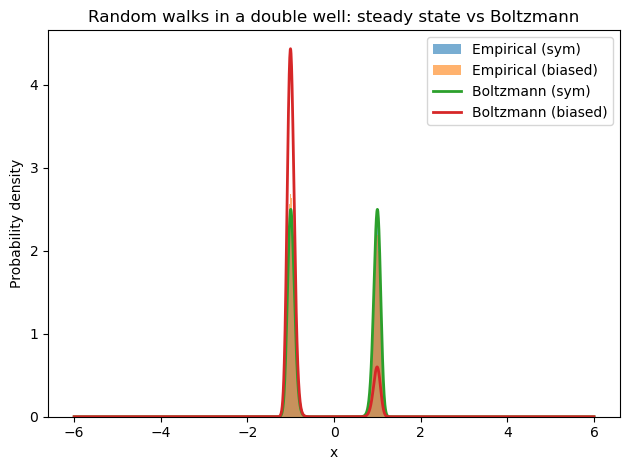

In [7]:
# Overdamped Langevin random walks in a symmetric double well:
#   dx = -(1/γ) V'(x) dt + sqrt(2 kT / γ) dW_t
# We simulate many walkers to steady state and estimate left/right occupancy.

import numpy as np
import matplotlib.pyplot as plt

# ---- Potential and parameters (ħ, m not needed here) ----
def V(x, V0=10.0, a=1.0, bias=0.0):
    # Symmetric quartic double well with optional linear bias term (breaks L/R symmetry)
    # V(x) = V0 * ((x^2/a^2) - 1)^2 + bias * x
    return V0 * ((x*x)/(a*a) - 1.0)**2 + bias * x

def dVdx(x, V0=10.0, a=1.0, bias=0.0):
    # d/dx of V
    return 4.0*V0*x*(x*x/(a*a) - 1.0)/(a*a) + bias

# ---- Langevin simulator (Euler–Maruyama) ----
def simulate_langevin(
    n_walkers=20000,            # number of independent walkers
    n_steps=20000,              # total steps
    dt=1e-3,                    # time step
    gamma=1.0,                  # friction γ
    kT=0.5,                     # thermal energy k_B T
    V0=10.0, a=1.0, bias=0.0,   # potential params
    x0=0.0,                     # initial position for all walkers
    burn_frac=0.5,              # fraction of steps discarded as burn-in
    L_box=6.0,                  # soft reflecting walls at ±L_box (avoid blow-ups)
    seed=7
):
    rng = np.random.default_rng(seed)
    x = np.full(n_walkers, x0, dtype=float)
    sqrt2Ddt = np.sqrt(2.0 * kT / gamma * dt)
    n_burn = int(burn_frac * n_steps)

    # Evolve
    for t in range(n_steps):
        drift = -(1.0/gamma) * dVdx(x, V0, a, bias) * dt
        noise = sqrt2Ddt * rng.standard_normal(n_walkers)
        x += drift + noise
        # soft reflecting boundary (clip and reflect velocity implicitly)
        mask = x > L_box
        x[mask] = 2*L_box - x[mask]
        mask = x < -L_box
        x[mask] = -2*L_box - x[mask]
        if t == n_burn:  # start collecting after burn-in
            xsamples = []

        if t >= n_burn:
            xsamples.append(x.copy())

    xsamples = np.stack(xsamples, axis=0)   # (n_keep, n_walkers)
    x_flat = xsamples.reshape(-1)           # pooled steady-state samples
    frac_left = np.mean(x_flat < 0.0)
    frac_right = 1.0 - frac_left
    return x_flat, frac_left, frac_right

# ---- Theoretical Boltzmann fractions via numerical integration ----
def boltzmann_fractions(kT=0.5, V0=10.0, a=1.0, bias=0.0, L=6.0, n=200000):
    x = np.linspace(-L, L, n, dtype=float)
    w = np.exp(-V(x, V0, a, bias) / kT)
    Z = np.trapz(w, x)
    ZL = np.trapz(w[x < 0.0], x[x < 0.0])
    ZR = Z - ZL
    return ZL/Z, ZR/Z

# ---- Run a baseline symmetric case (should → ~50/50) ----
x_ss, fL, fR = simulate_langevin(
    n_walkers=20000, n_steps=20000, dt=1e-3,
    gamma=1.0, kT=0.5, V0=10.0, a=1.0, bias=0.0,
    x0=0.0, burn_frac=0.5, L_box=6.0, seed=7
)
bL, bR = boltzmann_fractions(kT=0.5, V0=10.0, a=1.0, bias=0.0, L=6.0, n=200000)
print(f"Empirical steady-state fractions (symmetric): left={fL:.4f}, right={fR:.4f}")
print(f"Boltzmann prediction (symmetric):            left={bL:.4f}, right={bR:.4f}")

# ---- Slightly biased case (tilt potential) ----
x_ss_b, fL_b, fR_b = simulate_langevin(
    n_walkers=20000, n_steps=20000, dt=1e-3,
    gamma=1.0, kT=0.5, V0=10.0, a=1.0, bias=0.5,   # linear tilt
    x0=0.0, burn_frac=0.5, L_box=6.0, seed=11
)
bL_b, bR_b = boltzmann_fractions(kT=0.5, V0=10.0, a=1.0, bias=0.5, L=6.0, n=200000)
print(f"Empirical steady-state fractions (biased):   left={fL_b:.4f}, right={fR_b:.4f}")
print(f"Boltzmann prediction (biased):               left={bL_b:.4f}, right={bR_b:.4f}")

# ---- Plot steady-state histograms vs Boltzmann densities ----
fig, ax = plt.subplots()
bins = 200
ax.hist(x_ss, bins=bins, density=True, alpha=0.6, label="Empirical (sym)")
ax.hist(x_ss_b, bins=bins, density=True, alpha=0.6, label="Empirical (biased)")

xx = np.linspace(-6, 6, 2000)
ax.plot(xx, np.exp(-V(xx, 10.0, 1.0, 0.0)/0.5) / np.trapz(np.exp(-V(xx, 10.0, 1.0, 0.0)/0.5), xx), lw=2, label="Boltzmann (sym)")
ax.plot(xx, np.exp(-V(xx, 10.0, 1.0, 0.5)/0.5) / np.trapz(np.exp(-V(xx, 10.0, 1.0, 0.5)/0.5), xx), lw=2, label="Boltzmann (biased)")

ax.set_xlabel("x")
ax.set_ylabel("Probability density")
ax.set_title("Random walks in a double well: steady state vs Boltzmann")
ax.legend()
plt.tight_layout()
plt.show()

'/Users/william/program_repos/cphy/hw'